# Import statements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import pathlib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

2.17.0


# Preprocessing 

In [3]:
# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(selected_classes, normalize=True):
    dog_class_directory = os.getcwd()+'/dog_classes'
    
    total_sum = np.zeros(3)  # Assuming RGB images
    total_count = 0

    for class_name in selected_classes:
        class_dir = os.path.join(dog_class_directory, class_name)
        if not os.path.isdir(class_dir):
            print(f"Directory for class '{class_name}' not found, skipping.")
            continue
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.jpg', '.jpeg', '.png')):  # Adjust as needed for your image types
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                
                if normalize:
                    img_array /= 255.0  # Normalize to [0, 1]
                    
                total_sum += np.mean(img_array, axis=(0, 1))  # Mean over width, height for each channel
                total_count += 1

    if total_count == 0:
        print("No images found for the selected classes.")
        return None
    
    dataset_mean = total_sum / total_count
    return dataset_mean

In [4]:
# Zero-centering function
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Modify the dataset to apply zero-centering and normalization
def apply_zero_centering(dataset, dataset_mean, normalize=True):
    # Apply feature-wise centering and optional normalization
    def process_image(img, label):
        if normalize:
            img = img / 255.0  # Normalize to [0, 1] if normalize is True
        img = zero_centering(img, dataset_mean)  # Zero-center the image
        return img, label

    # Apply feature-wise centering and normalization by mapping the function
    zero_centered_dataset = dataset.map(
        process_image,
        num_parallel_calls=tf.data.AUTOTUNE  # Use parallel calls for efficiency
    )

    return zero_centered_dataset

# Model training

In [80]:
def get_classes(n: int):
    dog_class_directory = os.getcwd()+'/dog_classes'
    return os.listdir(dog_class_directory)[:n]

# See the classes to train on
#selected_classes = get_classes(10)

# 5 white coloured breeds, but dissimilar appearence 
#selected_classes = ['214-n000033-Bedlington_terrier', '211-n000058-Sealyham_terrier', '209-n000040-West_Highland_white_terrier', '225-n000073-Great_Pyrenees']


#8 breeds with bad balance
#selected_classes = ['3580-n000122-Labrador_retriever', '3083-n000117-Bichon_Frise', '207-n000011-Irish_setter', '224-n000039-Irish_wolfhound', '217-n000050-bluetick', '235-n000097-clumber', '234-n000065-whippet', '253-n000105-Cane_Carso']


#breeds that look like a labrador
selected_classes = ['3580-n000122-Labrador_retriever', '206-n000047-flat_coated_retriever', '5355-n000126-golden_retriever', '202-n000028-curly_coated_retriever', '210-n000048-vizsla', '211-n000059-German_short_haired_pointer', '230-n000080-Rhodesian_ridgeback', '235-n000096-Weimaraner']
print(len(selected_classes))
print(selected_classes)

8
['3580-n000122-Labrador_retriever', '206-n000047-flat_coated_retriever', '5355-n000126-golden_retriever', '202-n000028-curly_coated_retriever', '210-n000048-vizsla', '211-n000059-German_short_haired_pointer', '230-n000080-Rhodesian_ridgeback', '235-n000096-Weimaraner']


In [81]:
# Print the number of elements (images) in each class
dog_class_directory = os.getcwd() + '/dog_classes'  # Define the directory path again

for c in selected_classes:
    class_directory = os.path.join(dog_class_directory, c)  # Full path to the class folder
    # List files in the class folder and count them
    num_images = len([f for f in os.listdir(class_directory) if os.path.isfile(os.path.join(class_directory, f))])
    print(f"Class '{c}' has {num_images} images.")


Class '3580-n000122-Labrador_retriever' has 3580 images.
Class '206-n000047-flat_coated_retriever' has 206 images.
Class '5355-n000126-golden_retriever' has 5355 images.
Class '202-n000028-curly_coated_retriever' has 202 images.
Class '210-n000048-vizsla' has 210 images.
Class '211-n000059-German_short_haired_pointer' has 211 images.
Class '230-n000080-Rhodesian_ridgeback' has 230 images.
Class '235-n000096-Weimaraner' has 235 images.


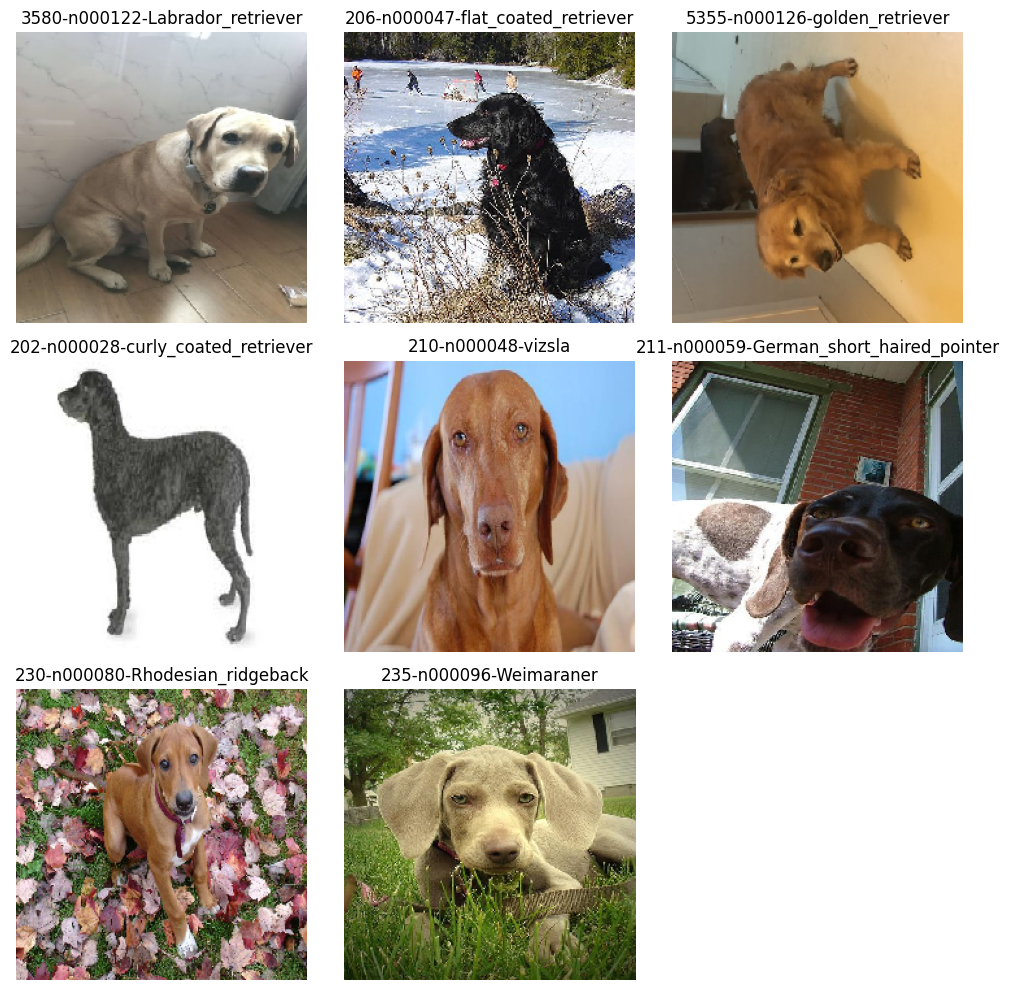

In [82]:
dog_class_directory = os.getcwd() + '/dog_classes'

# Set up the figure for displaying images
plt.figure(figsize=(10, 10))

# Loop over each class and display the first image
for i, class_name in enumerate(selected_classes):
    class_directory = os.path.join(dog_class_directory, class_name)
    image_files = os.listdir(class_directory)
    
    # Check if there are images in the class directory
    if image_files:
        first_image_path = os.path.join(class_directory, image_files[0])
        
        # Load and display the first image
        img = load_img(first_image_path, target_size=(224, 224))  # Resize for consistent display size
        ax = plt.subplot(3, 3, i + 1)  # Adjust grid as per number of classes
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [83]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

In [84]:
# Add new top layer
x = conv_base.output #the output of base model to go into top layers
x = GlobalAveragePooling2D()(x) #notsure
x = Dense(1024,activation='relu')(x) #dense layer, dafuq
#x = Dropout(0.5)(x)  # Dropout added here
preds = Dense(len(selected_classes),activation='softmax')(x) #final layer with softmax activation to make class predictions

# Specify model, combination of encoder and customised top layer
model = Model(inputs=conv_base.input, outputs=preds)

In [85]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [86]:
dog_class_directory = os.getcwd()+'/dog_classes'
dataset_mean = compute_dataset_mean(selected_classes, normalize=False)

In [87]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

Found 10229 files belonging to 8 classes.
Using 8184 files for training.
Found 10229 files belonging to 8 classes.
Using 2045 files for validation.


In [88]:
zero_norm_train_dataset = apply_zero_centering(train_dataset, dataset_mean, normalize=False)
zero_norm_val_dataset = apply_zero_centering(val_dataset, dataset_mean, normalize=False)

In [89]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(zero_norm_train_dataset, 
          validation_data=zero_norm_val_dataset, 
          epochs=50)

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 92s 356ms/step - accuracy: 0.6198 - loss: 1.0797 - val_accuracy: 0.7663 - val_loss: 0.6740
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 288ms/step - accuracy: 0.7644 - loss: 0.6415 - val_accuracy: 0.7848 - val_loss: 0.6138
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 78s 305ms/step - accuracy: 0.7904 - loss: 0.5652 - val_accuracy: 0.7736 - val_loss: 0.6155
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 77s 299ms/step - accuracy: 0.8050 - loss: 0.5291 - val_accuracy: 0.7883 - val_loss: 0.5907
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 73s 284ms/step - accuracy: 0.8227 - loss: 0.4856 - val_accuracy: 0.7790 - val_loss: 0.6012
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 74s 289ms/step - accuracy: 0.8352 - loss: 0.4595 - val_accuracy: 0.7985 - val_loss: 0.5679
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 294ms/step - accuracy: 0.8416 - loss: 0.4383 - val_accuracy: 0.7941 - val_loss: 0.5684
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 292ms/step - accuracy: 0.8524 - loss: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


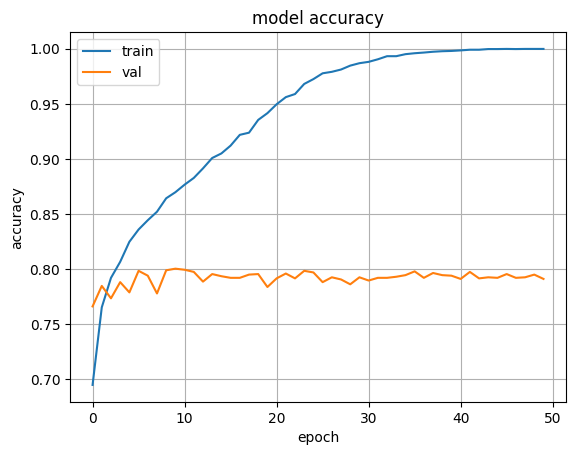

In [90]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

#### We are now ready to start training the model using


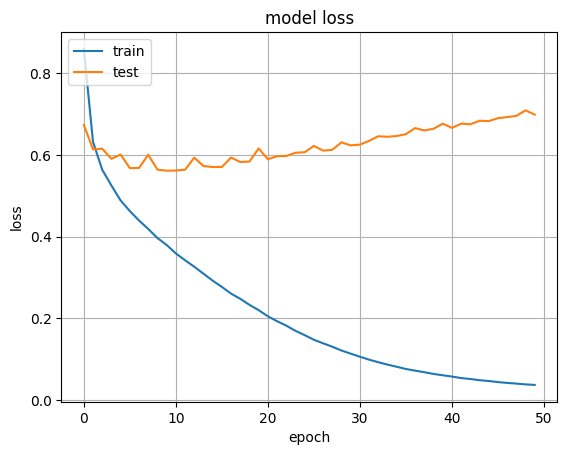

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

## Confusion matrix

In [92]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(zero_norm_val_dataset, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.7916 - loss: 0.6780
test loss, test acc: [0.6989197134971619, 0.7911980152130127]


In [93]:
x_test_list = []
y_test_list = []

# Iterate over each (x, y) in the dataset, taking only y (labels)
for img, labels in zero_norm_val_dataset:
    x_test_list.append(img.numpy())
    y_test_list.append(labels.numpy())  # Convert labels to NumPy array and add to list
    
x_test_array = np.vstack(x_test_list) 
y_test_array = np.vstack(y_test_list) 

In [94]:
# Generate predictions directly on the dataset
predictions = model.predict(x_test_array, verbose=False)
print('predictions shape:', predictions.shape)
print(predictions)

predictions shape: (2045, 8)
[[6.35e-01 2.19e-04 3.64e-01 ... 7.15e-06 3.35e-04 1.01e-05]
 [7.66e-02 6.56e-06 9.23e-01 ... 6.35e-07 1.09e-05 1.04e-06]
 [9.62e-03 1.85e-05 9.90e-01 ... 4.39e-07 5.42e-06 3.33e-07]
 ...
 [4.84e-04 8.92e-06 9.99e-01 ... 2.45e-09 2.16e-05 1.60e-07]
 [2.58e-03 2.52e-06 9.97e-01 ... 6.03e-06 2.64e-04 3.77e-06]
 [2.72e-01 3.32e-06 7.28e-01 ... 1.03e-07 2.11e-04 2.21e-06]]


In [76]:
y_test_class = np.argmax(y_test_array, axis=1)
predictions_class = np.argmax(predictions,axis=1)
print('predictions.shape:',predictions.shape)
print('predictions_class.shape:',predictions_class.shape)

predictions.shape: (343, 8)
predictions_class.shape: (343,)


In [95]:
print('predictions_class[:20]',predictions_class[:20])
print('y_test_class[:20]     ',y_test_class[:20])

predictions_class[:20] [1 1 4 6 7 2 2 7 7 3 2 6 3 2 7 2 1 7 6 7]
y_test_class[:20]      [1 1 4 2 7 4 2 7 7 1 2 6 3 3 7 5 1 2 6 5]


In [99]:
import numpy as np

# Use the get_accuracy function
def get_accuracy(predictions_class, y_test):
    # Convert one-hot encoded y_test to class indices
    y_test_class = np.argmax(y_test, axis=1)
    # Calculate number of correct predictions
    num_correct = np.sum(predictions_class == y_test_class)
    # Calculate accuracy
    accuracy = num_correct / len(y_test_class)
    return accuracy

# Assuming predictions_class contains predicted class indices
accuracy = get_accuracy(predictions_class, y_test_array)
print('accuracy:', accuracy)

accuracy: 0.0


Confusion matrix, without normalization
Normalized confusion matrix


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

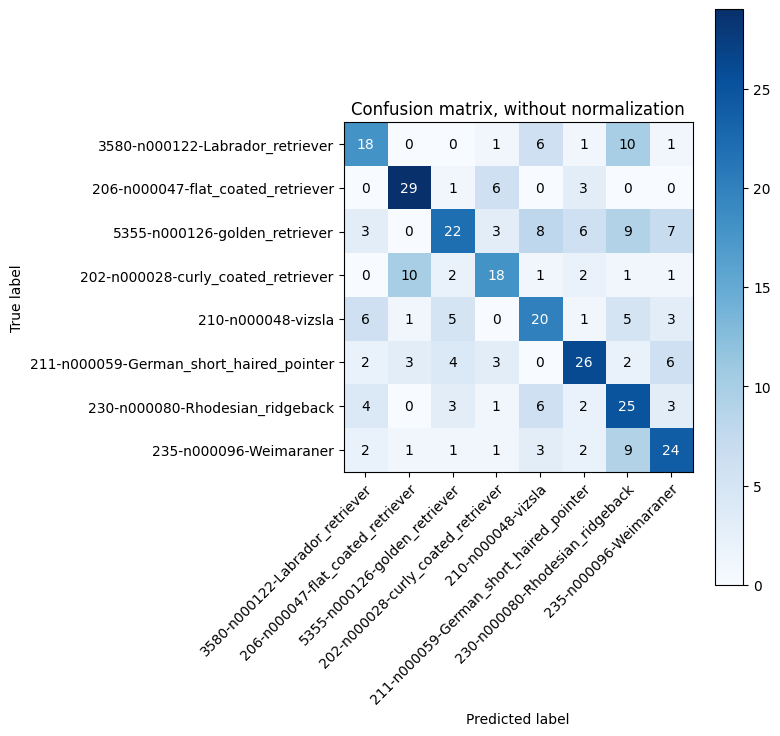

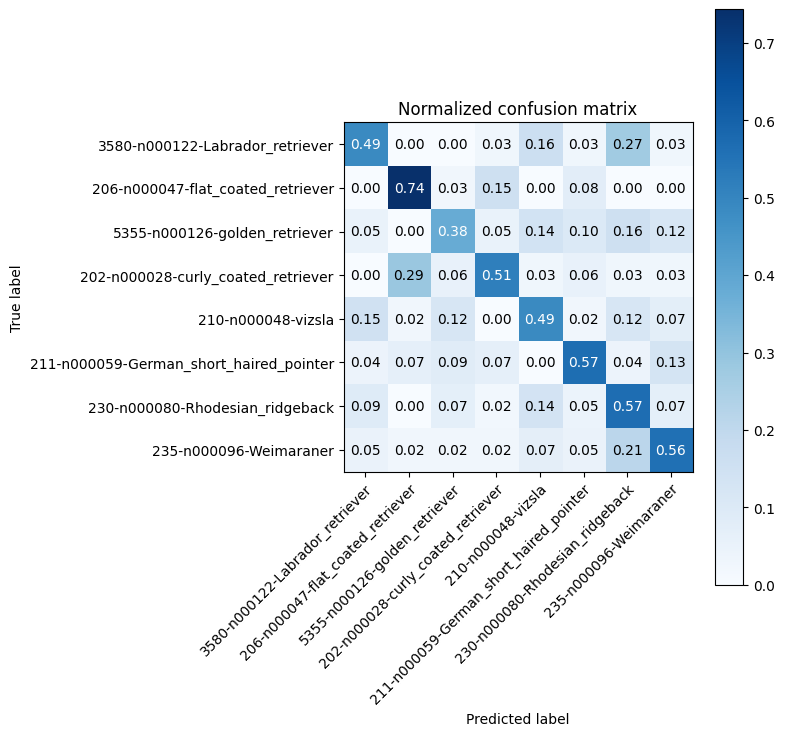

In [98]:
# From:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(8,8))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
labels = selected_classes
N = predictions_class.shape[0]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_class[:N], predictions_class, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_class[:N], predictions_class, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [61]:
print("Shape of y_test_class:", y_test_class.shape)
print("Shape of predictions_class:", predictions_class.shape)


Shape of y_test_class: (343,)
Shape of predictions_class: (343,)
